# Cluster Analysis

In [1]:
# First we import all neccessary libraries and give some of them an alias for easy access
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import cm
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Read in the data so every group member can run the notebook on his machine
# (our repo is on github, we therefore have the same file structure)
df = pd.read_csv("./Data/Transformed/inventory_management_cleaned_transformed.csv")
df.shape # Get a first idea about the number of rows and columns of the dataset

(1722, 10)

In [3]:
# Check the data
df.head()

,Category,Region,Inventory Level,Price,Discount,Weather Condition,Promotion,Demand,Product_UID,Weekday
0,1,1,-0.399386,0.084333,-0.601533,1,0,0.038863,S001_P0001,2
1,0,1,-0.737767,0.268861,0.707999,1,1,2.633833,S001_P0002,2
2,0,1,-0.173798,-0.158233,0.053233,1,1,0.994905,S001_P0003,2
3,1,1,-0.642326,0.454134,0.053233,1,0,-1.395199,S001_P0004,2
4,3,1,-0.585929,-0.369795,-1.256300,1,0,-1.235859,S001_P0005,2


In [4]:
# We look at the data to decide how to handle the grouping with categorial data attributes
df[df['Product_UID'] == "S001_P0001"][['Category', 'Region', 'Weather Condition', 'Weekday']]

,Category,Region,Weather Condition,Weekday
0,1,1,1,2
100,1,1,1,3
200,1,1,1,1
300,1,1,1,5
400,1,1,1,6
500,1,1,2,4
600,1,1,1,0
700,1,1,1,2
800,1,1,2,3
900,1,1,0,1


In [5]:
# We group the data by the unique Product_UID, now we are able to look at specific products
# We exclude Weather Condition and Weekday from clustering because they represent external, short-term conditions rather than intrinsic product characteristics
# We exclude promotion as this is our target variable and KMeans is unsupervised
# We take the mean of all numerical attributes and the first value of the non numerical attributes as these are always the same
agg_df = df.groupby('Product_UID').agg({
    'Price': 'mean',
    'Discount': 'mean',
    'Inventory Level': 'mean',
    'Demand': 'mean',
    'Category': 'first',
    'Region': 'first'
}).reset_index()

In [6]:
# Check the aggregated dataframe, we see that we have 100 unique products and their mean characteristics
agg_df

,Product_UID,Price,Discount,Inventory Level,Demand,Category,Region
0,S001_P0001,-0.045300,0.053233,-0.248994,-0.224174,1,1
1,S001_P0002,0.089831,0.162361,-0.508564,1.214946,0,1
2,S001_P0003,-0.279075,0.053233,0.400775,0.562410,0,1
3,S001_P0004,0.571972,0.198737,-0.510010,-0.823597,1,1
4,S001_P0005,-0.265364,0.235113,1.524615,0.250053,3,1
...,...,...,...,...,...,...,...
95,S005_P0016,-0.866584,-0.139345,0.437891,-0.070934,4,1
96,S005_P0017,-0.803455,-0.139345,-0.614000,-0.053527,4,1
97,S005_P0018,-1.164094,0.053233,-0.581336,0.286577,0,1
98,S005_P0019,1.584706,-0.023798,-0.562707,-0.626616,2,1


In [7]:
# We Store the unique identifier column in a variable and then drop it for the analysis as it has no meaning for the clustering
product_ids = agg_df['Product_UID']
features = agg_df.drop(columns=['Product_UID'])

In [8]:
# We apply a full Principal Component Analysis (PCA) to get the number of Components 
# for a cummulative explained variance of 85%
pca = PCA()
pcadf = pca.fit_transform(features)
pcadf = pd.DataFrame(pcadf, columns = ['PC'+str(i) for i in range(1, pcadf.shape[1]+1)])
pcadf.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.952274,-0.504209,-0.554400,-0.459095,-0.364329,0.063473
1,-1.829932,-0.804680,-1.398600,-0.422107,0.897636,0.101564
2,-1.677200,-0.757337,-1.510922,0.244803,-0.057409,0.026490
3,-1.252302,-0.558578,0.166644,-0.790755,-0.649863,0.222306
4,0.880483,-0.410108,-0.050988,1.485705,-0.208932,0.219718


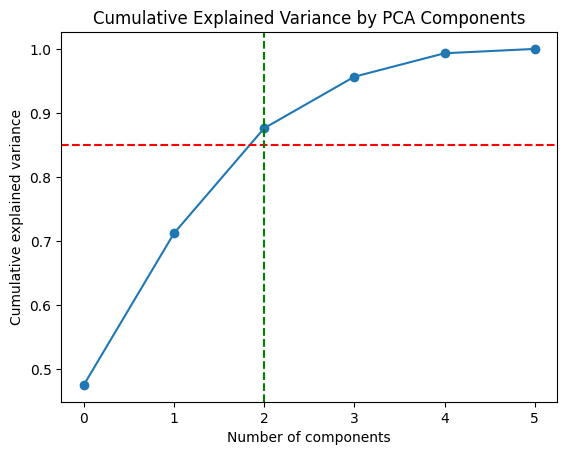

In [9]:
# We visualize the explained variance of the full PCA
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance, marker = 'o')
# We add horizontal dashed line at y = 0.85 to roughly visualize the number of components at the 0.85 level
plt.axhline(y=0.85, color='r', linestyle='--')
# We can see this is roughly at k = 2 which stands for 3 components
plt.axvline(x=2, color='g', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.show()

In [10]:
# We want to confirm that we need k = 3 dimensions to explain 85% of cummulative explained variance
pca_85 = PCA(n_components=0.85)
pcadf = pca_85.fit_transform(features)
k = pca_85.n_components_
print(k)

3


In [11]:
# We conduct the PCA again, this time with our optimal number of dimensions
pca_opt = PCA(n_components= k)
pcadf_opt = pca_opt.fit_transform(features)
pcadf_opt = pd.DataFrame(pcadf_opt, columns=['PC' + str(i) for i in range(1, pcadf_opt.shape[1]+1)])
Y_np_opt = pcadf_opt.to_numpy()
pcadf_opt.head(5)

,PC1,PC2,PC3
0,-0.952274,-0.504209,-0.554400
1,-1.829932,-0.804680,-1.398600
2,-1.677200,-0.757337,-1.510922
3,-1.252302,-0.558578,0.166644
4,0.880483,-0.410108,-0.050988


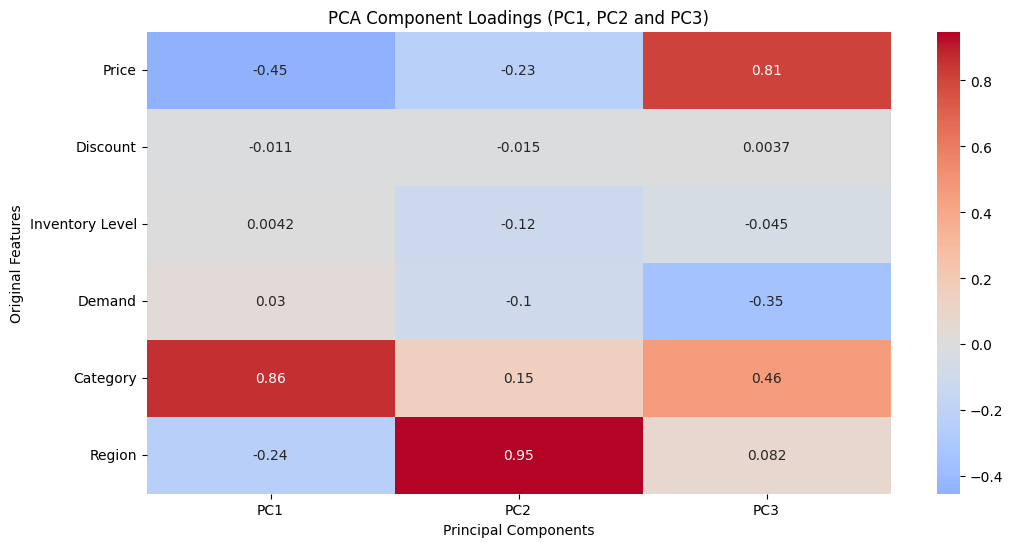

In [12]:
# We want to regain some of the lost explainability by looking out of which attributes the PCAs are composed
loadings = pd.DataFrame(pca_opt.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca_85.n_components_)],
                        index=features.columns)
plt.figure(figsize=(12, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Component Loadings (PC1, PC2 and PC3)')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()

### K Nearest Neighbour (KNN)

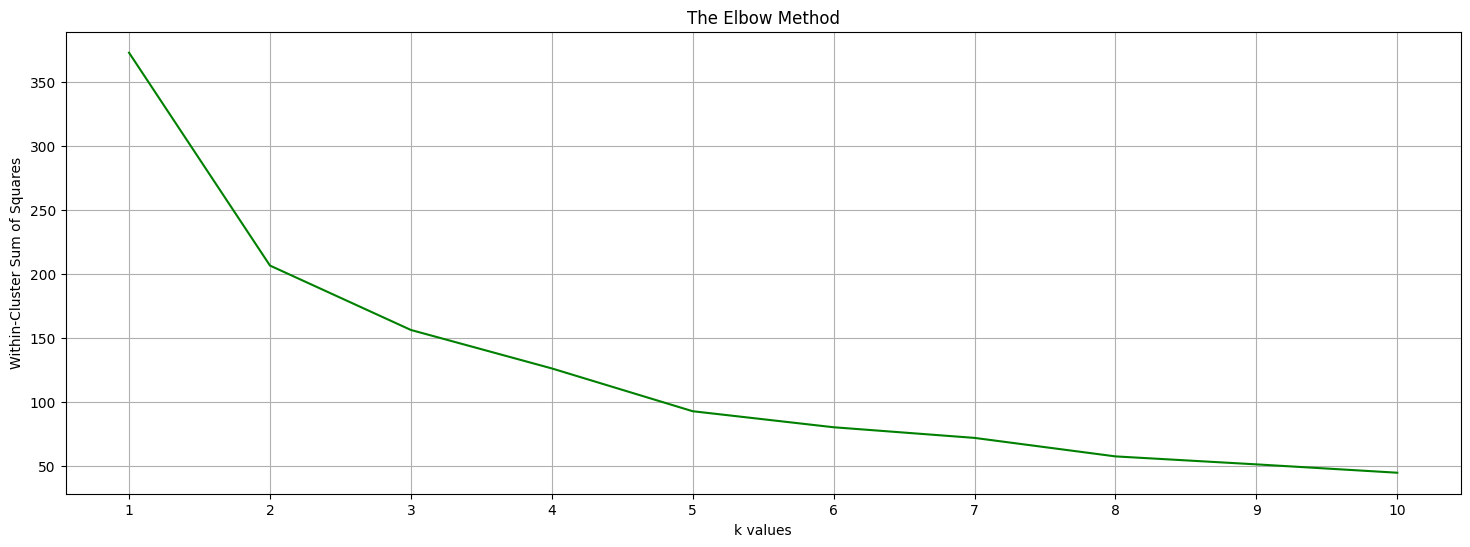

In [13]:
# We get a first hint about the optimal number of clusters with the elbow criteria
inertia_score = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pcadf_opt)
    inertia_score.append(kmeans.inertia_)

# We visualize the inertia scores to identify the elbow point
plt.figure(figsize=(18,6))
sns.lineplot(x=range(1,11),y=inertia_score,color='green')
plt.xticks(range(1,11))
plt.xlabel('k values')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('The Elbow Method')
plt.grid()
plt.show()

In [14]:
# We try out the number of clusters that our elbow criteria suggests us
kmeans = KMeans(n_clusters=3, init="k-means++", n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(pcadf_opt)

In [15]:
# Because our optimal 3 dimensions can be viualized, we use plotly to generate an interactive scatter plot. This helps gain further insights and understand the data better due to the visualization
plot_df = pd.DataFrame(pcadf_opt)
plot_df['Cluster'] = y_kmeans.astype(str)

fig = px.scatter_3d(
    plot_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='Interactive 3D KMeans Clustering',
    opacity=0.8,
    size_max=6,            
    size=[5]*len(plot_df), 
    color_discrete_sequence=px.colors.qualitative.Set1
)

# Add cluster centers as big black X marks
centers = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centers, columns=['PC1', 'PC2', 'PC3'])
centroids_df['Cluster'] = ['Centroid'] * len(centers)

fig.add_trace(
    px.scatter_3d(
        centroids_df,
        x='PC1',
        y='PC2',
        z='PC3',
        color='Cluster',
        size=[12]*len(centers),
        symbol_sequence=['x'],
        color_discrete_sequence=['black']
    ).data[0]
)

fig.update_traces(marker=dict(line=dict(width=0)))  
fig.update_layout(
    legend_title_text='Clusters',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

fig.show()

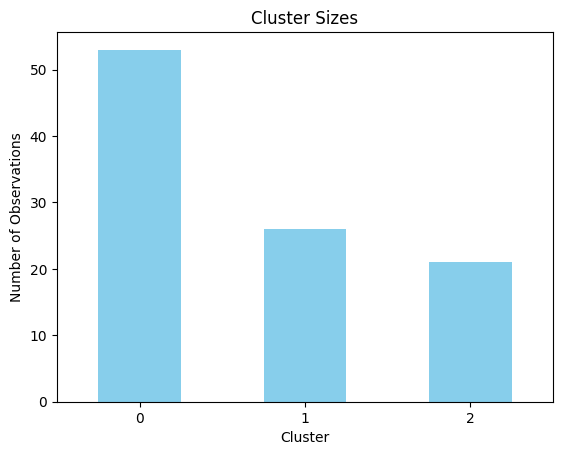

In [16]:
# For further insights we analyze how the observations in the data are distributed in the different clusters
pd.Series(y_kmeans).value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.show()

In [17]:
# We calculate the silhouette score for the number of clusters that our elbow criteria suggested us
silhouette_score(pcadf_opt, y_kmeans)

np.float64(0.3965781548646818)

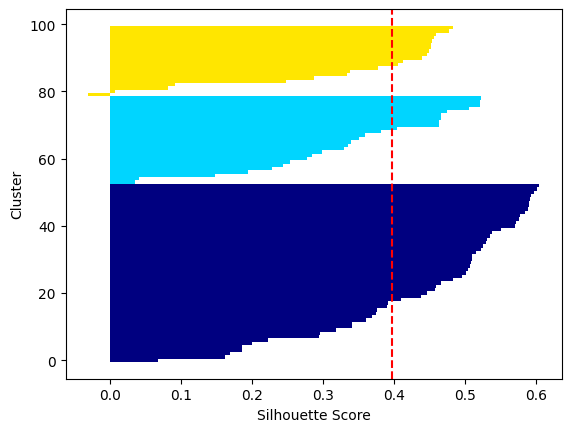

In [18]:
# We visualize the average silhouette scores for k=3 based on the elbow criteria
cluster_labels = np.unique(y_kmeans)
n_clusters=cluster_labels.shape [0]

silhouette_vals = silhouette_samples(pcadf_opt, y_kmeans, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_kmeans == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet( i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height = 1.0,
            edgecolor = 'none',
            color = color)
    yticks.append((y_ax_lower + y_ax_upper) / 2 )
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = "--")
plt.ylabel('Cluster')
plt.xlabel('Silhouette Score')
plt.show()

In [19]:
# We can calculate the silhouette scores of different numbers of clusters to evaluate the optimal number of clusters with a simple for loop
best_k = None
best_score = -1

for k in range(2, 9): 
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    y_kmeans = kmeans.fit_predict(pcadf_opt)
    score = silhouette_score(pcadf_opt, y_kmeans)
    print("The silhouette score for k = ",k," is ",score)
    
    if score > best_score:
        best_score = score
        best_k = k

print("Best k:",best_k,"with a silhouette score of ",best_score)

The silhouette score for k =  2  is  0.40762724508564374
The silhouette score for k =  3  is  0.3965781548646818
The silhouette score for k =  4  is  0.3617178485749837
The silhouette score for k =  5  is  0.3820201979726507
The silhouette score for k =  6  is  0.3703378631786309
The silhouette score for k =  7  is  0.37363441104673634
The silhouette score for k =  8  is  0.4004379380926871
Best k: 2 with a silhouette score of  0.40762724508564374


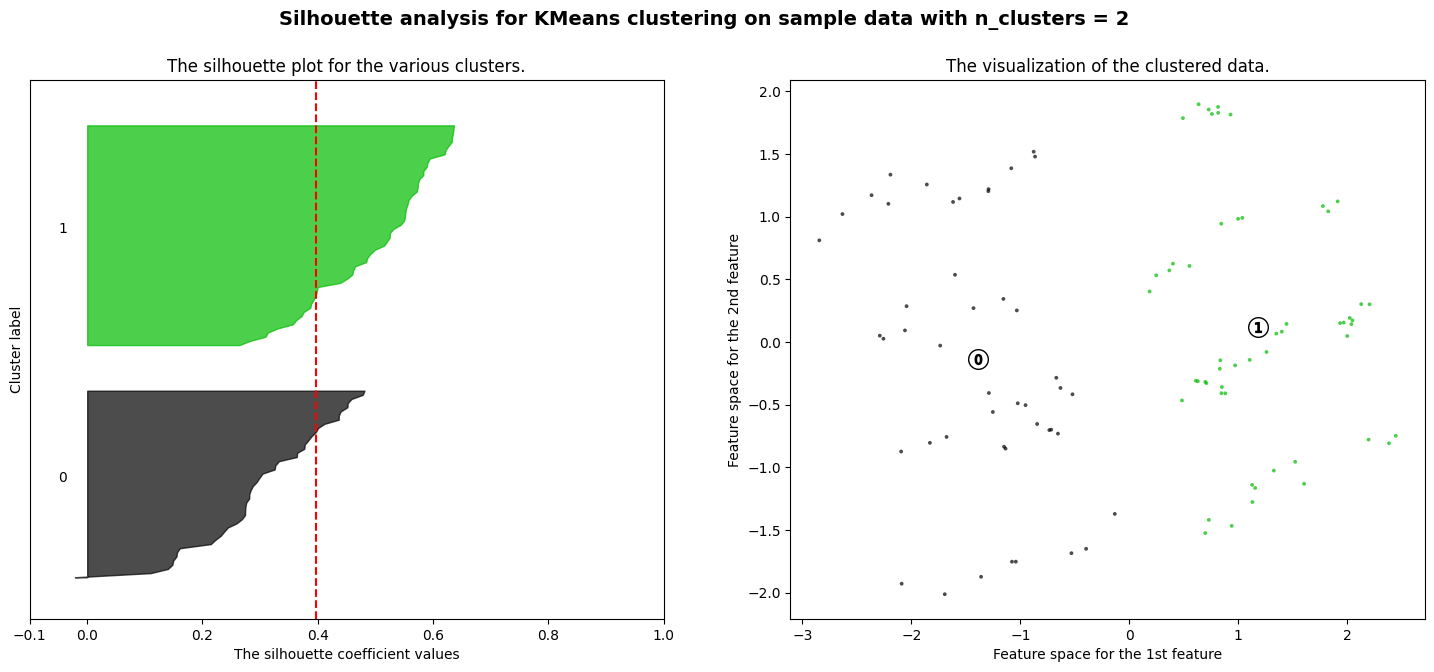

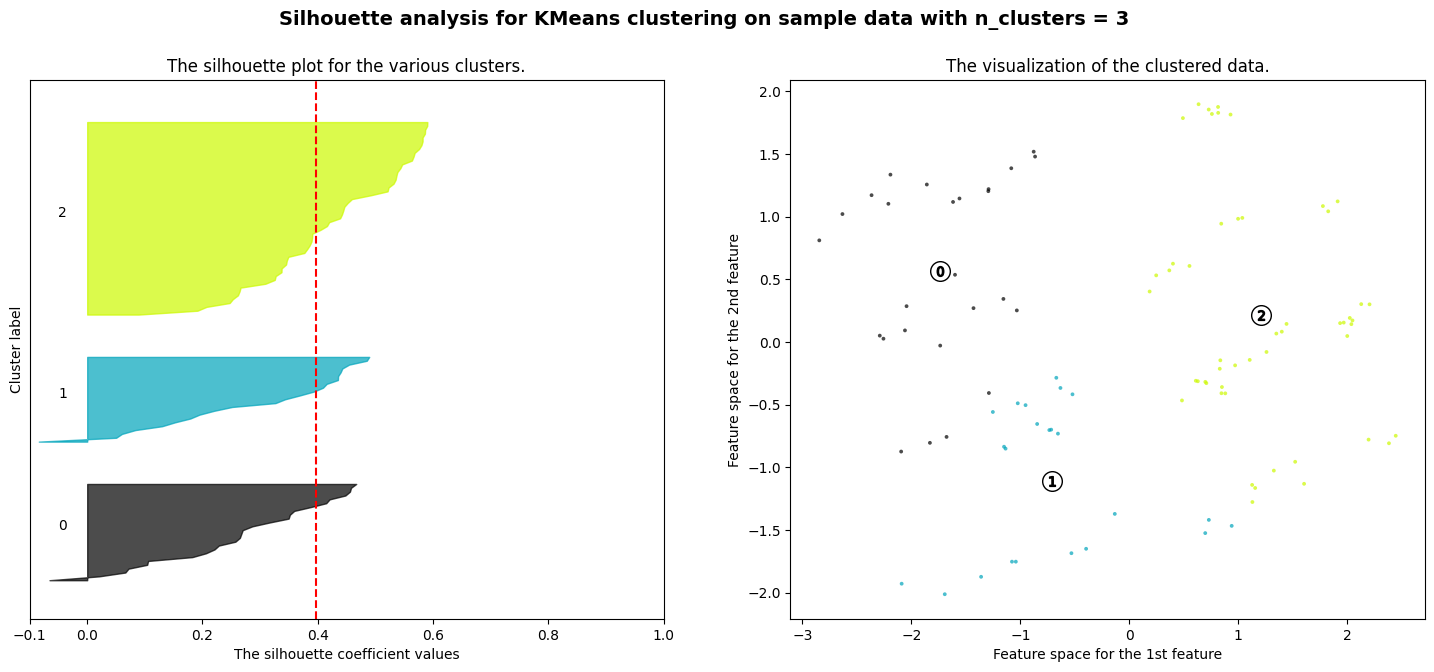

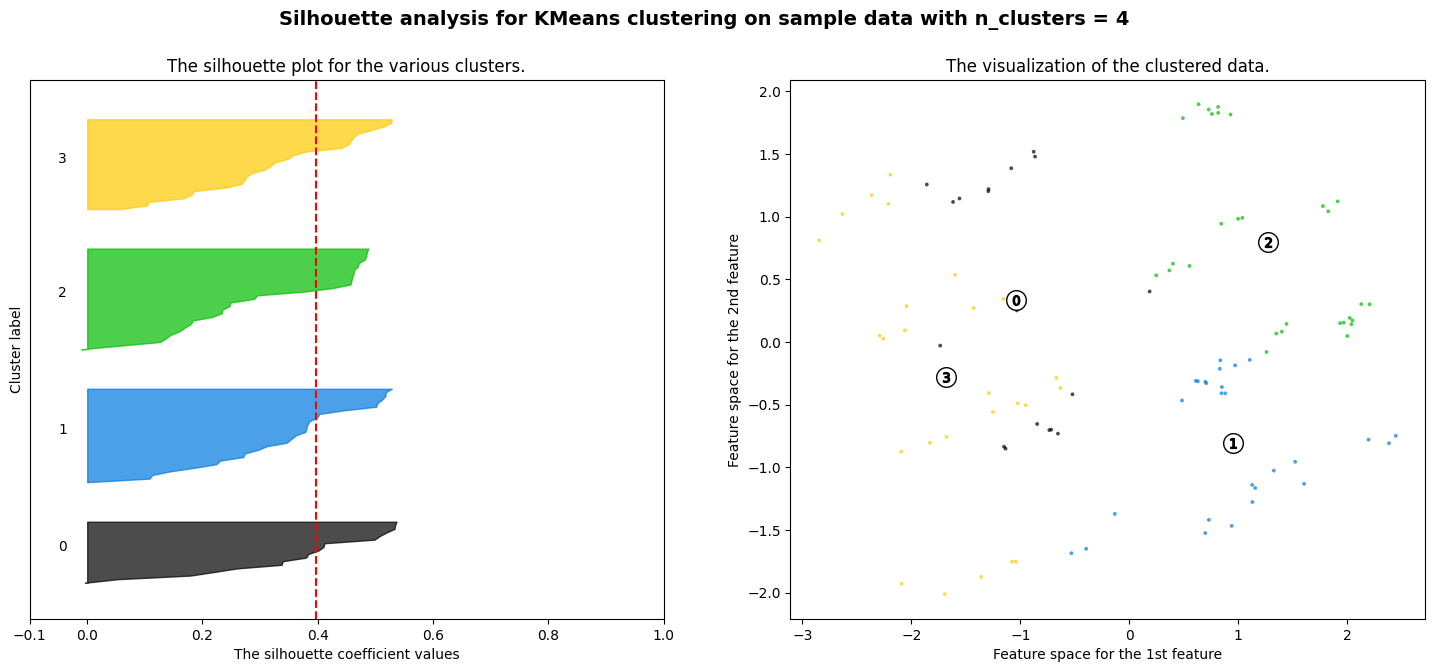

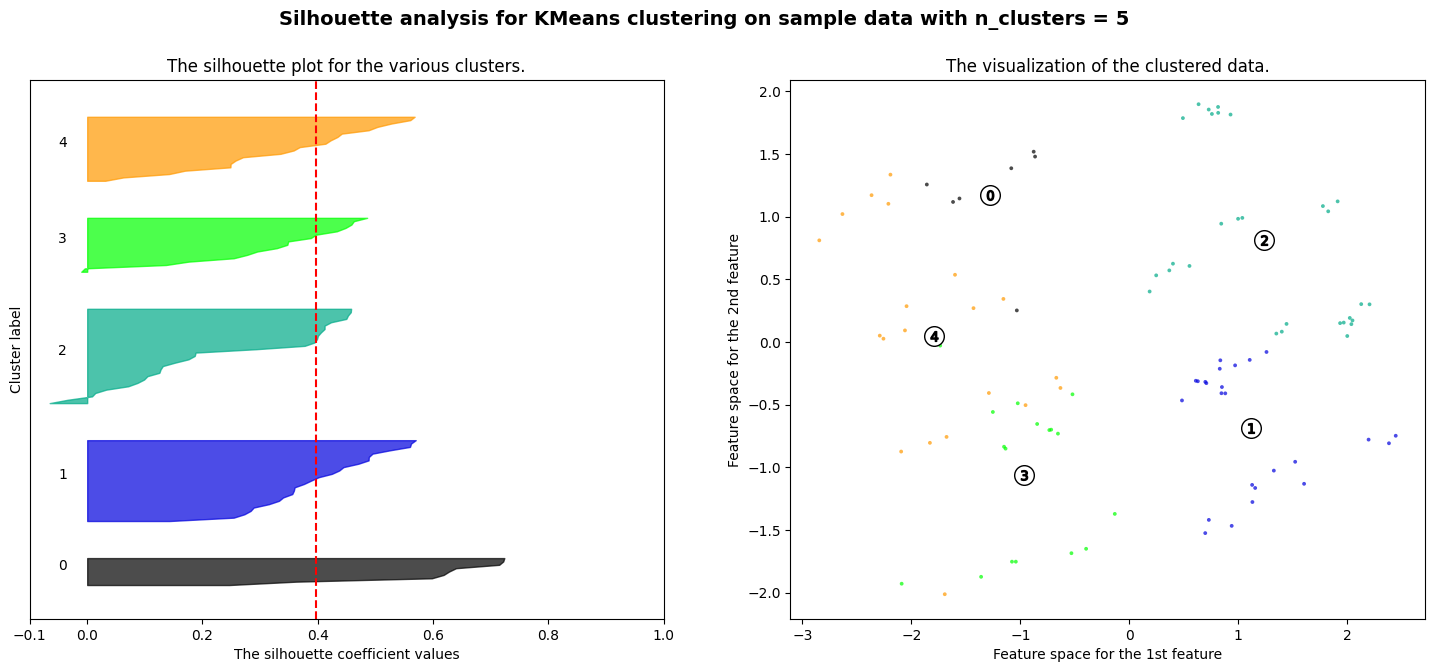

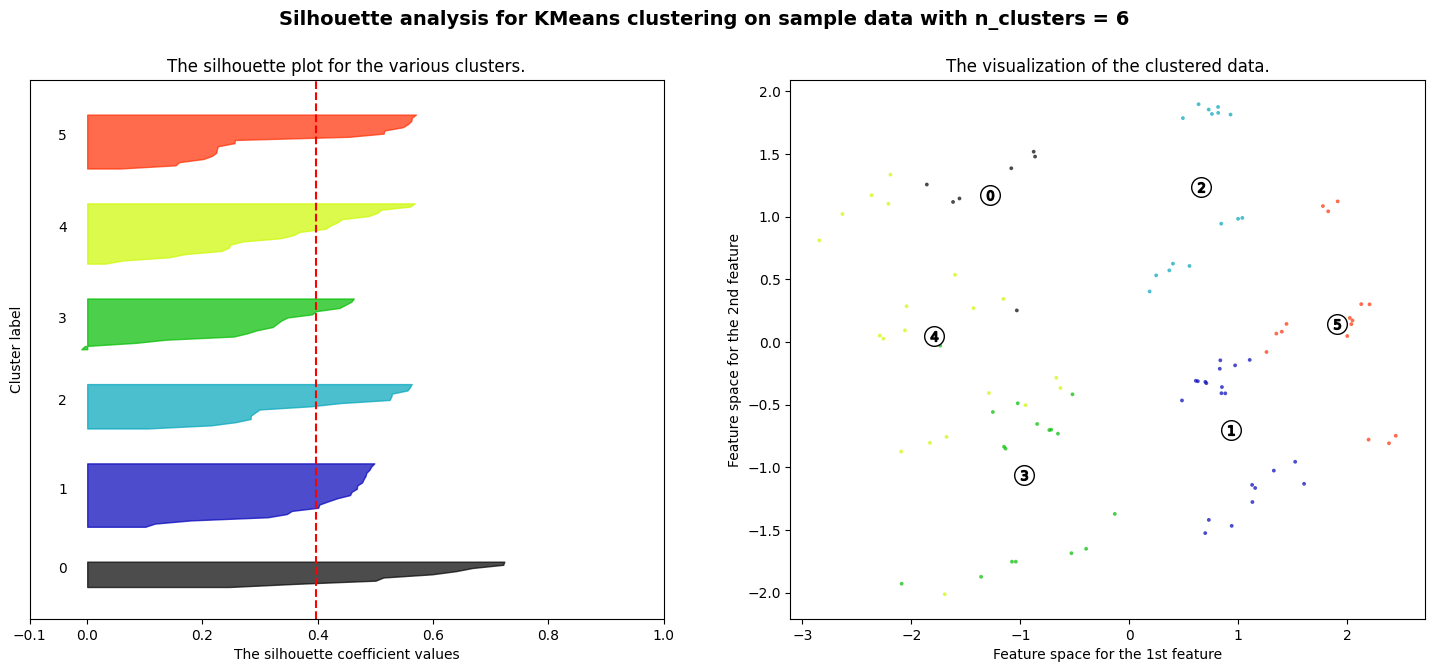

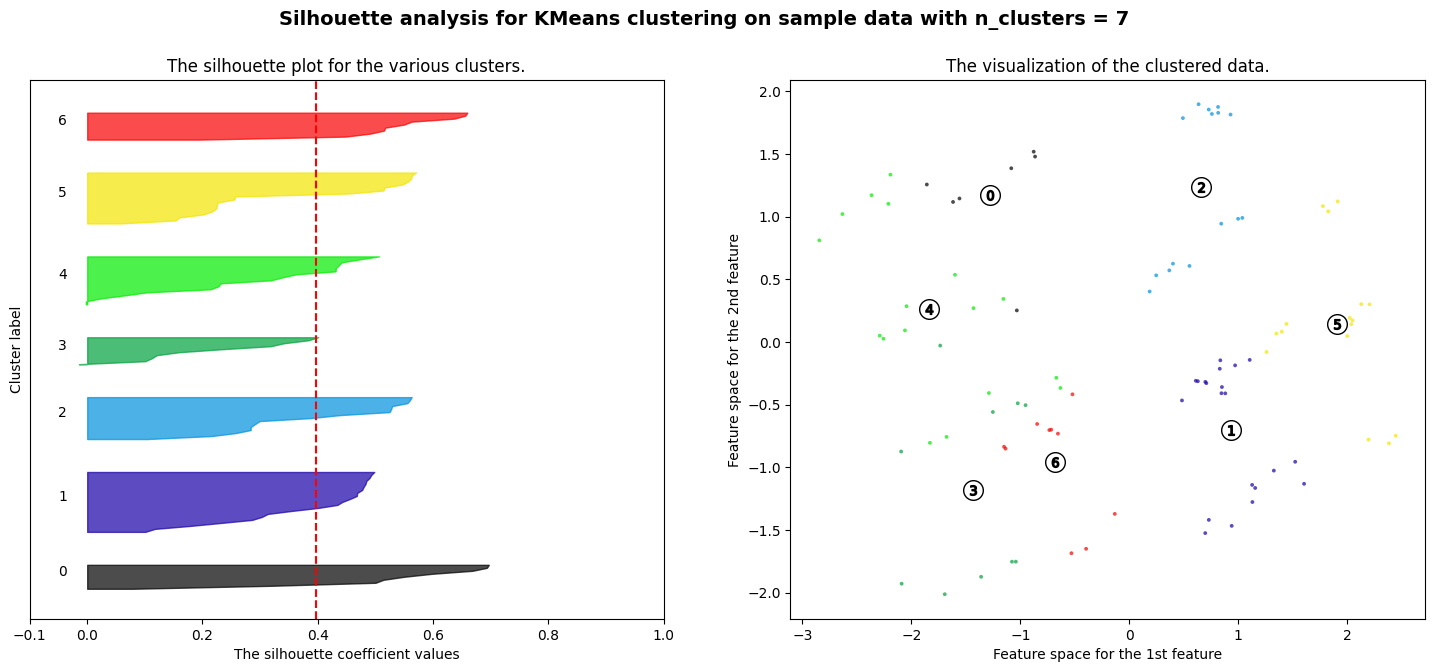

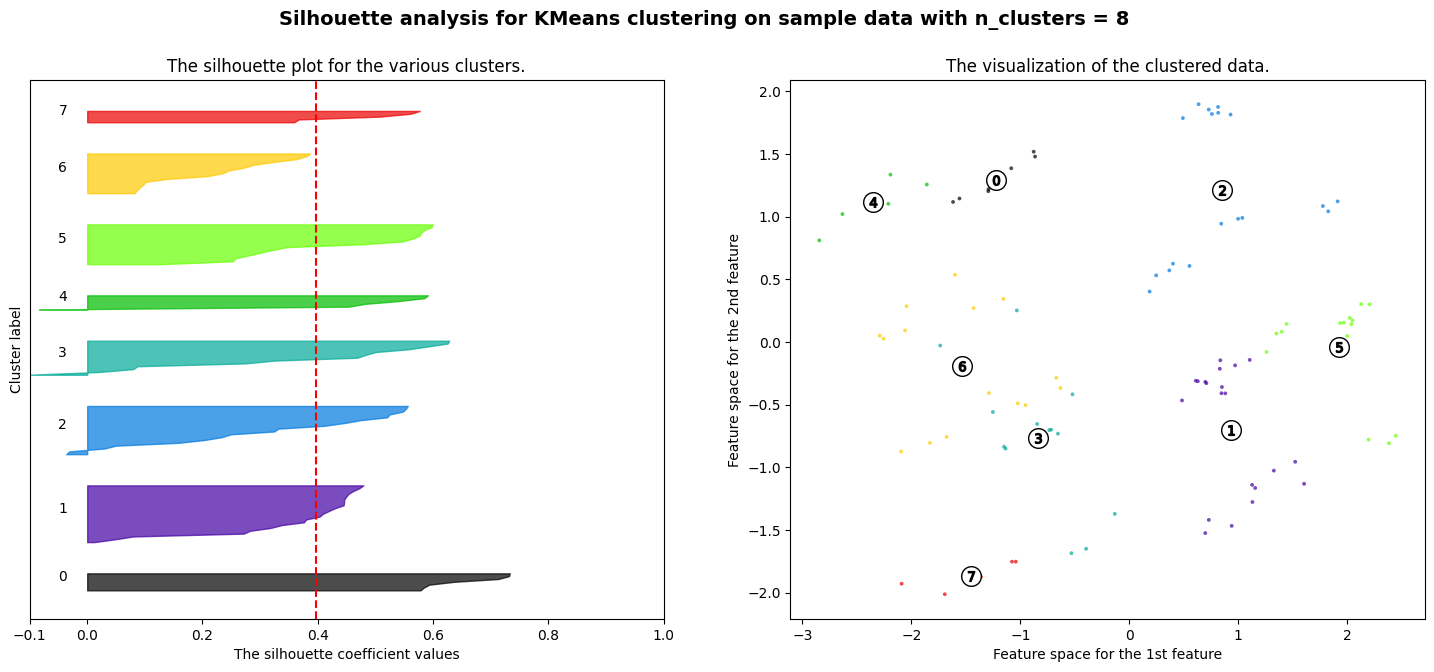

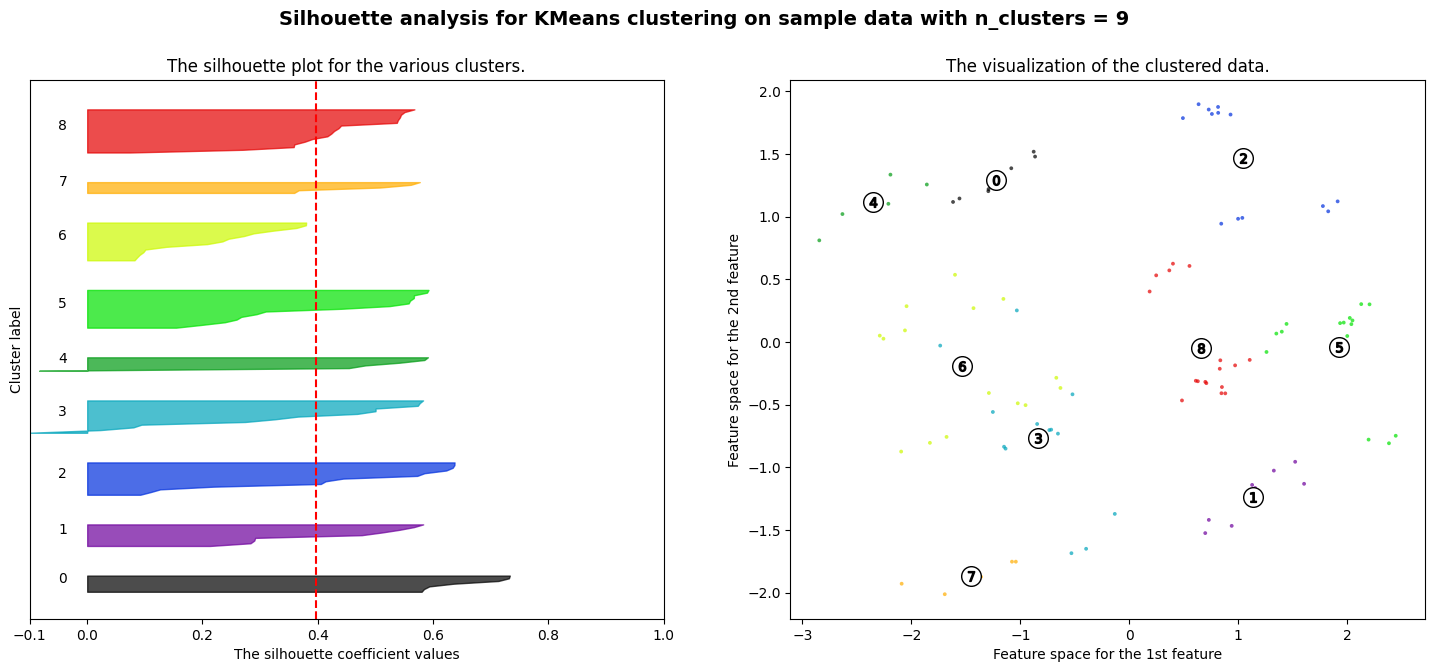

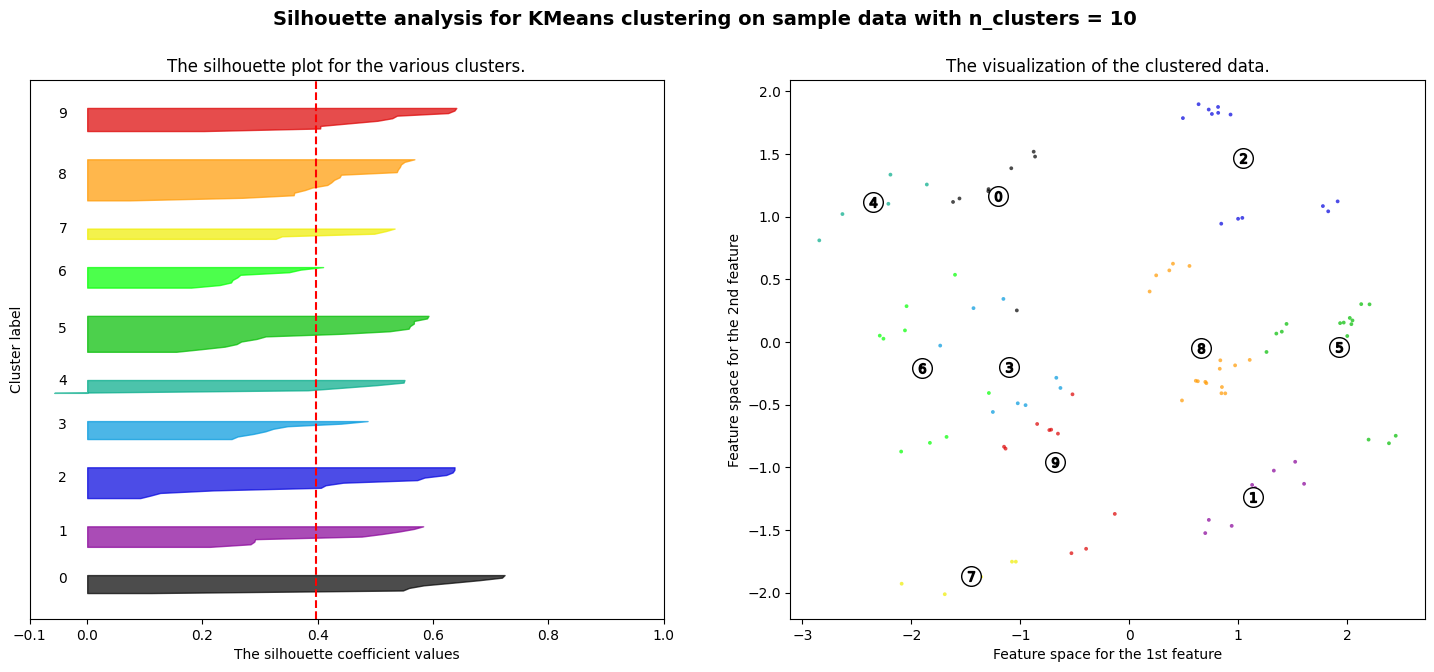

In [20]:
# We plot different silhouette scores of different numbers of clusters to confirm that k=2 is the optimal choice
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Y_np_opt) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Y_np_opt)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Y_np_opt, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Y_np_opt[:, 0], Y_np_opt[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [21]:
# We will have a detailed look at the clusters for the optimal k = 2
kmeans = KMeans(n_clusters=2, init="k-means++", n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(pcadf_opt)

In [22]:
# Because our optimal 2 dimensions can be viualized, we use plotly to generate an interactive scatter plot. This helps gain further insights and understand the data better due to the visualization
plot_df = pcadf_opt.copy()
plot_df['Cluster'] = y_kmeans.astype(str)

fig = px.scatter_3d(
    plot_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='Interactive 3D KMeans Clustering',
    opacity=0.8,
    size_max=6,           
    size=[5]*len(plot_df), 
    color_discrete_sequence=px.colors.qualitative.Set1
)

# Add cluster centers as big black X marks
centers = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centers, columns=['PC1', 'PC2', 'PC3'])
centroids_df['Cluster'] = ['Centroid'] * len(centers)

fig.add_trace(
    px.scatter_3d(
        centroids_df,
        x='PC1',
        y='PC2',
        z='PC3',
        color='Cluster',
        size=[12]*len(centers),
        symbol_sequence=['x'],
        color_discrete_sequence=['black']
    ).data[0]
)

fig.update_traces(marker=dict(line=dict(width=0))) 
fig.update_layout(
    legend_title_text='Clusters',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

fig.show()

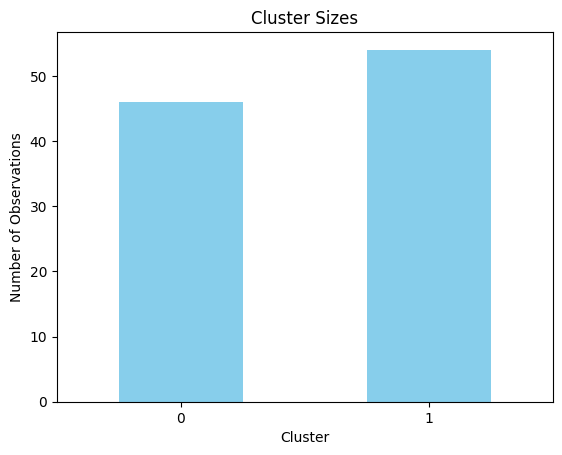

In [23]:
# For further insights we analyze how the observations in the data are distributed in the different clusters
pd.Series(y_kmeans).value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.show()

In [24]:
# This again shows the silhoutte score for an optimal number of clusters k = 2
silhouette_score(pcadf_opt, y_kmeans)

np.float64(0.40762724508564374)

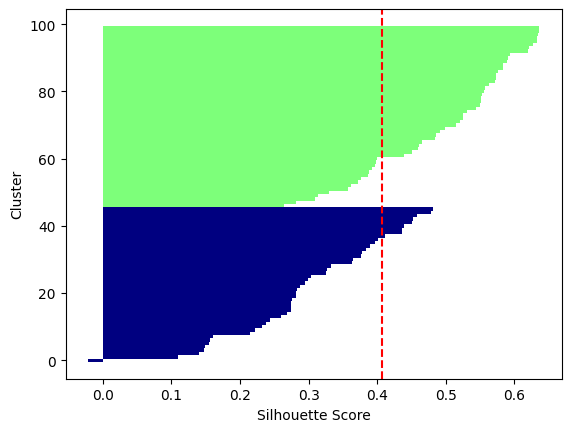

In [25]:
# We visualize the average silhouette scores for the optimal k
cluster_labels = np.unique(y_kmeans)
n_clusters=cluster_labels.shape [0]

silhouette_vals = silhouette_samples(pcadf_opt, y_kmeans, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_kmeans == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet( i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height = 1.0,
            edgecolor = 'none',
            color = color)
    yticks.append((y_ax_lower + y_ax_upper) / 2 )
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = "--")
plt.ylabel('Cluster')
plt.xlabel('Silhouette Score')
plt.show()

In [26]:
# We add back the unique identifier column
pcadf_opt["Product_UID"] = product_ids.values

# Store and interpert the Cluster Data

In [27]:
# Read in the data to join the cluster labels with the original dataframe
df_orig = pd.read_csv("./Data/Transformed/inventory_management_cleaned.csv")

In [28]:
# Step 1: Prepare cluster labels
# `product_ids` contains Product_UIDs used for clustering (from agg_df)
# `y_kmeans` contains the corresponding cluster labels

cluster_map = pd.DataFrame({
    "Product_UID": product_ids.values,  # from agg_df
    "Clusterlabel": y_kmeans            # from KMeans
})

# Step 2: Ensure Product_UID in both DataFrames is the same type
df_orig["Product_UID"] = df_orig["Product_UID"].astype(str)
cluster_map["Product_UID"] = cluster_map["Product_UID"].astype(str)

# Step 3: Merge cluster labels into the original data
df_orig = df_orig.merge(cluster_map, on="Product_UID", how="left")

In [29]:
# Store the data
df_orig.to_csv("./Data/Transformed/inventory_management_cleaned_transformed_with_labels_opt.csv", index=False)

In [30]:
# We look at the mean values of the numerical attributes per cluster to gain insights into possible patterns
# We can see that they differ in price significantly
df_orig_num = df_orig.select_dtypes(include=[np.number])
cluster_profiles = df_orig_num.groupby("Clusterlabel").mean().round(2)
display(cluster_profiles)

,Inventory Level,Price,Discount,Promotion,Demand
Clusterlabel,,,,,
0,273.36,96.92,9.73,0.36,105.60
1,298.73,45.82,9.47,0.36,119.85


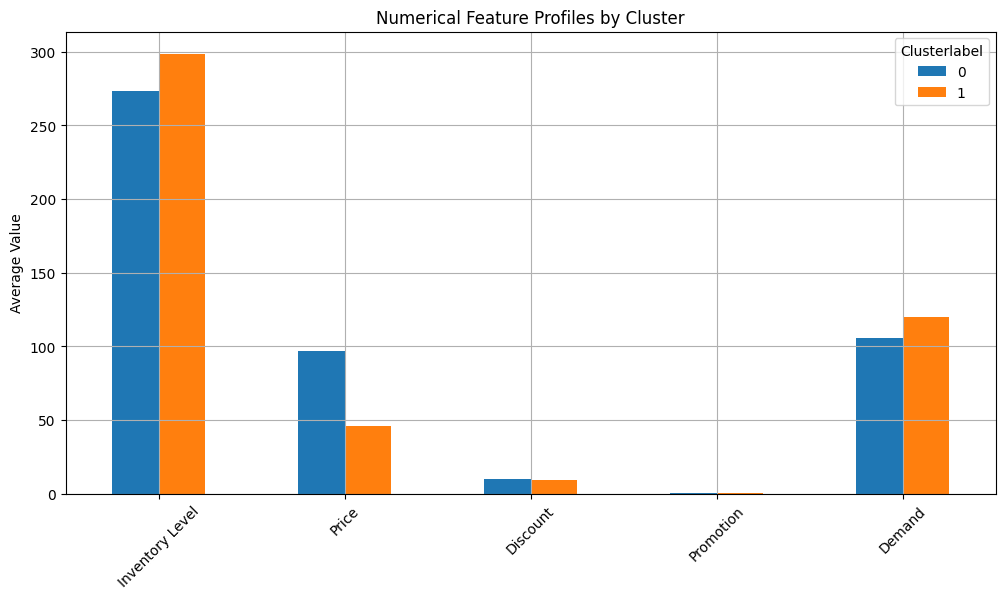

In [31]:
# We plot the different mean values of the numerical colunmns to compare them, we see that they differ in price significantly 
cluster_profiles.T.plot(kind='bar', figsize=(12,6))
plt.title("Numerical Feature Profiles by Cluster")
plt.ylabel("Average Value")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


Category Proportions by Cluster for 'Category':


Category,Clothing,Electronics,Furniture,Groceries,Toys
Clusterlabel,,,,,
0,0.35,0.26,0.39,0.00,0.00
1,0.00,0.00,0.00,0.74,0.26


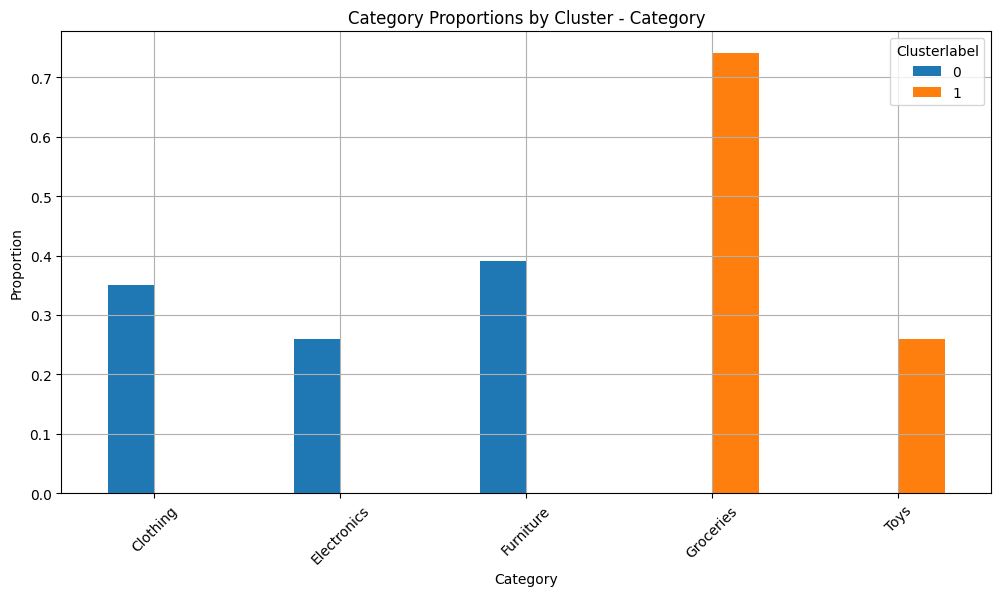


Category Proportions by Cluster for 'Region':


Region,East,North,South,West
Clusterlabel,,,,
0,0.17,0.36,0.19,0.28
1,0.22,0.45,0.20,0.13


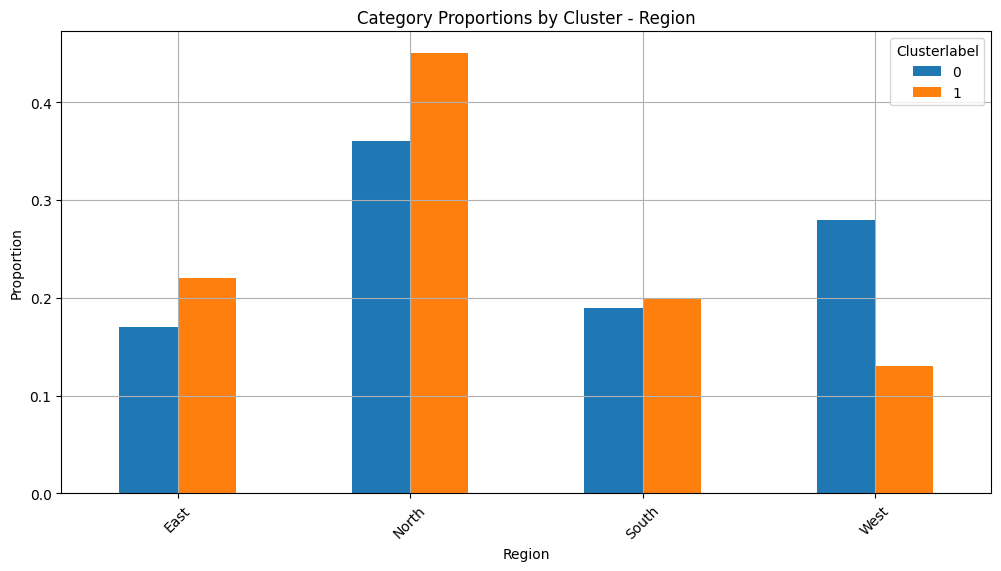


Category Proportions by Cluster for 'Weather Condition':


Weather Condition,Cloudy,Snowy,Sunny
Clusterlabel,,,
0,0.40,0.35,0.25
1,0.37,0.35,0.28


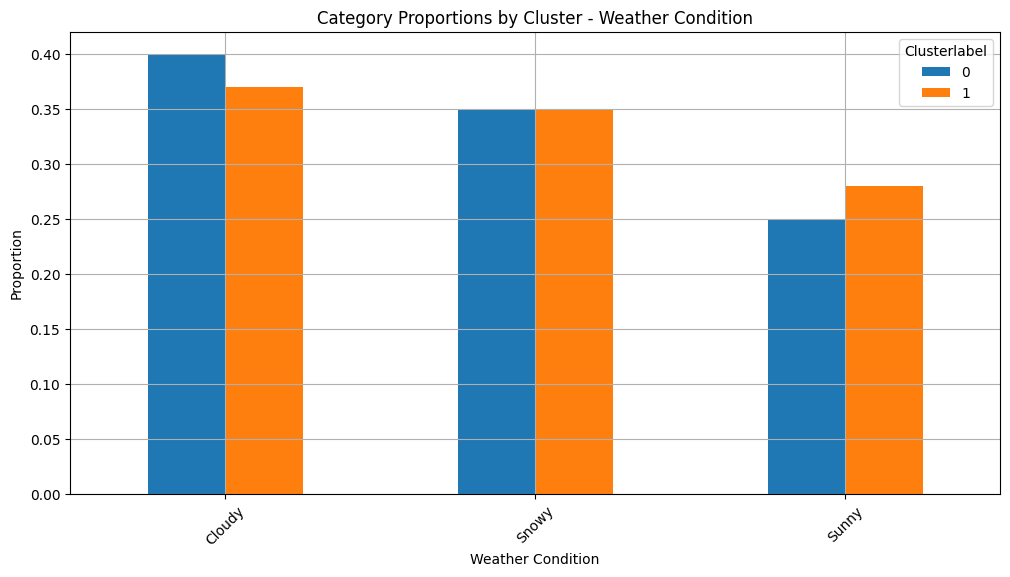


Category Proportions by Cluster for 'Weekday':


Weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Clusterlabel,,,,,,,
0,0.12,0.17,0.17,0.17,0.12,0.13,0.12
1,0.12,0.17,0.17,0.17,0.12,0.13,0.12


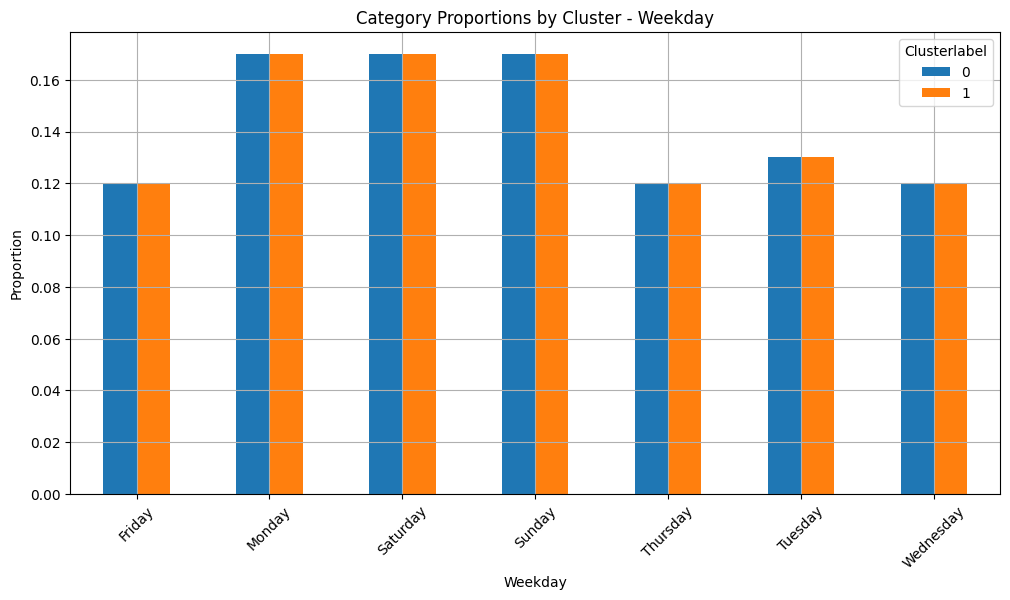

In [32]:
# Select non-numeric (categorical) columns, excluding 'Product_UID' to plot them for the different clusters
df_orig_cat = df_orig.select_dtypes(exclude=[np.number]).drop(columns=["Product_UID"])

# Combine with cluster labels
df_cat_with_clusters = df_orig_cat.copy()
df_cat_with_clusters["Clusterlabel"] = df_orig["Clusterlabel"]

# Calculate proportions of each category per cluster
cat_profiles = {}
for col in df_cat_with_clusters.columns:
    if col != "Clusterlabel":
        proportions = df_cat_with_clusters.groupby("Clusterlabel")[col].value_counts(normalize=True).unstack().fillna(0)
        cat_profiles[col] = proportions.round(2)

# Display results
for col, df in cat_profiles.items():
    print(f"\nCategory Proportions by Cluster for '{col}':")
    display(df)

    # Plotting
    df.T.plot(kind='bar', figsize=(12, 6))
    plt.title(f"Category Proportions by Cluster - {col}")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [33]:
# We see that the categories are unique for the clusters, deviding them into higher priced and lower priced or fast-moving and non-fast-moving goods

In [34]:
# Read in the data to join the cluster labels with the original dataframe to run a decision tree on them
df_orig_unscaled = pd.read_csv("./Data/Transformed/inventory_management_cleaned_transformed_unscaled.csv")

In [35]:
# Step 1: Prepare cluster labels
# `product_ids` contains Product_UIDs used for clustering (from agg_df)
# `y_kmeans` contains the corresponding cluster labels

cluster_map = pd.DataFrame({
    "Product_UID": product_ids.values,  # from agg_df
    "Clusterlabel": y_kmeans            # from KMeans
})

# Step 2: Ensure Product_UID in both DataFrames is the same type
df_orig_unscaled["Product_UID"] = df_orig_unscaled["Product_UID"].astype(str)
cluster_map["Product_UID"] = cluster_map["Product_UID"].astype(str)

# Step 3: Merge cluster labels into the original data
df_orig_unscaled = df_orig_unscaled.merge(cluster_map, on="Product_UID", how="left")

In [36]:
# Store the data for the decision tree on the cluster labels
df_orig_unscaled.to_csv("./Data/Transformed/inventory_management_cleaned_transformed_unscaled_with_labels.csv", index =False)